# IMDG Genie

## Project Name: 
IMDG Genie

## Service Summary: 
Support users who has any IMDG Code related question and provide relevant information in natrual language but only based on IMDG Code book

## Definition Problem:
The contents in IMDG Code is huge and very specialized information. It is required a long-term experience to understand the details in IMDG Code. Also, English based code book makes difficult to understand intuitive way

## Prompt:
"Tell me about IMDG class 3."

"I need to understand about limited quantity."

"Provide requirements for handling marine pollutants."


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [1]:
import os
import openai
import gradio as gr
from dotenv import load_dotenv
from langchain_openai import OpenAI

load_dotenv('api.env') 
api_key = os.getenv('OPENAI_API_KEY')

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

In [3]:
# # 파이썬으로 pdf 파일을 읽기 위한 라이브러리입니다.
# !pip install -q pypdf

# # 벡터 데이터베이스를 지원합니다.
# !pip install -q chromadb

# # 토큰을 계산하는 라이브러리입니다.
# !pip install -q tiktoken

In [4]:
# from langchain.embeddings.openai import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.document_loaders import PyPDFLoader

In [5]:
# pdf 파일을 읽습니다.
loader = PyPDFLoader("/Users/kenny_jung/Documents/GitHub/IMDG.pdf") 
documents = loader.load()

In [6]:
# pdf 파일의 내용을 1000글자씩 자릅니다.
text_splitter = CharacterTextSplitter(chunk_size=3000, chunk_overlap=500)
texts= text_splitter.split_documents(documents)

In [7]:
len(texts)

1080

In [8]:
# 결과가 어떻게 나왔을까요?
texts

[Document(page_content="INCBRPBRATlNS A삐IENBI삐'ENT 39-'8 INTERNATIONAL \nMARITIME \n。RGANIZATION", metadata={'source': '/Users/kenny_jung/Documents/GitHub/IMDG.pdf', 'page': 0}),
 Document(page_content='Contents \nPage \nForeword ... XI \nPreamble ................... . X川\nPART 1 GENERAL PROVISIONS , DEFINITIONS AND TRAINING \nChapter 1.1 General provisions \n1.1.0 Introductorynote................................................ 3 \n1.1.1 Application and implementation of the Code. . . . . . . . . . . . . . . . . . . . . . . . . . 3 \n1.1.2 Conventions................................................... 4 \n1.1.3 Dangerous goods forbidden from transport . . . . . . . . . . . . . . . . . . . . . . . . . . 12 \nChapter 1.2 Definitions , units of measurement and abbreviations \n1.2.1 \n1.2.2 \n1.2.3 Definitions .. \nUnits of measurement. \nList of abbreviations . 엽 \n낀 \n감 \nChapter 1.3 Training \n1.3.0 Introductory note. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [9]:
# pdf의 내용을 임베딩(embedding)하여 벡터 데이터베이스에 저장합니다.
# 임베딩: 텍스트를 모델이 이해할 수 있는 벡터(숫자들의 배열) 형태로 변환하는 것

embeddings = OpenAIEmbeddings()
vector_store = Chroma.from_documents(texts, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

In [18]:
# 랭체인의 대화 모델을 불러옵니다.
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain

# GPT-4를 사용할 수 있다면 gpt-3.5-turbo 대신 gpt-4를 쓰셔도 좋습니다.
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.5, max_tokens=500)

# 질의응답을 위한 체인을 정의합니다.
chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever = retriever,
    return_source_documents=True)

In [19]:
query = "Tell me about class 9"
result = chain(query)
print(result)

{'question': 'Tell me about class 9', 'answer': 'Class 9 substances and articles (miscellaneous dangerous substances and articles) are substances and articles which, during transport, present a danger not covered by other classes. They are assigned to class 9 if they are not covered by other classes and are of such a dangerous character that specific provisions shall apply. Class 9 substances and articles are classified based on their characteristics and properties that do not fit into other specific classes.\n', 'sources': '/Users/kenny_jung/Documents/GitHub/IMDG.pdf', 'source_documents': [Document(page_content='Chapter 2.9 \nMiscellaneous dangerous substances and articles \n(class 9) and environmentally hazardous substances \nNote1: For the purposes of this Code, the environmentally hazardous substances (aquatic environment) criteria \ncontained in this chapter apply to the classification of marine pollutants (see 2.1 이. \nNote 2: Although the environmentally hazardous substances (aq

In [20]:
print(result['answer'])

Class 9 substances and articles (miscellaneous dangerous substances and articles) are substances and articles which, during transport, present a danger not covered by other classes. They are assigned to class 9 if they are not covered by other classes and are of such a dangerous character that specific provisions shall apply. Class 9 substances and articles are classified based on their characteristics and properties that do not fit into other specific classes.



In [21]:
print(result['sources'])

/Users/kenny_jung/Documents/GitHub/IMDG.pdf


In [22]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

system_template="""
You are IMDG Code specialist who has a deep understanding of the International Maritime Dangerous Goods (IMDG) Code. You are asked to provide detailed information about the questions.

Use the following pieces of context to answer the users question in details.

Given the following summaries of a long document and a question, create a final answer with references ("SOURCES"), use "SOURCES" in capital letters regardless of the number of sources.

Provide the information in a clear and concise manner in a way that is easy to understand. 

Provide the feedback with bullet points to list the information in organized manner.

If the question is not clear, ask the user to clarify the question.

If the question is asking about UN No. or UN Number of four(4) digits basis, please answer with reference to the pdf file from page 572 to 913.

If the question made by Korean, please answer in Korean.

If you don't know the answer, just say that "I don't know", don't try to make up an answer.
----------------
{summaries}
"""

# If you don't know the answer, just say that "I don't know", don't try to make up an answer.

messages = [
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template("{question}")
]

prompt = ChatPromptTemplate.from_messages(messages)

In [23]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain

chain_type_kwargs = {"prompt": prompt}

# GPT-4를 사용할 수 있다면 gpt-3.5-turbo 대신 gpt-4를 쓰셔도 좋습니다.
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.5, max_tokens=500)

chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever = retriever,
    return_source_documents=True,
    chain_type_kwargs=chain_type_kwargs
)

In [24]:
query = "Tell me about classification 9."
result = chain(query)
print(result)

{'question': 'Tell me about classification 9.', 'answer': 'Before providing detailed information about Class 9, it is important to clarify that Class 9 is also known as "Miscellaneous dangerous substances and articles." Here are the key points regarding the classification of Class 9 substances and articles:\n\n- **Definition**: Class 9 substances and articles are those that, during transport, present a danger not covered by other classes.\n- **Assignment to Class 9**: \n  - Includes substances and articles not covered by other classes that are of such a dangerous character that specific provisions apply.\n  - Some substances are subject to the provisions of Annex III of MARPOL, while others may not be subject to these provisions but are categorized under Class 9.\n- **Subdivisions**:\n  - Substances that, when inhaled as fine dust, may endanger health.\n  - Substances evolving flammable vapour.\n  - Lithium batteries fall under Class 9, including lithium metal batteries, lithium ion ba

In [25]:
print(result['answer'])

Before providing detailed information about Class 9, it is important to clarify that Class 9 is also known as "Miscellaneous dangerous substances and articles." Here are the key points regarding the classification of Class 9 substances and articles:

- **Definition**: Class 9 substances and articles are those that, during transport, present a danger not covered by other classes.
- **Assignment to Class 9**: 
  - Includes substances and articles not covered by other classes that are of such a dangerous character that specific provisions apply.
  - Some substances are subject to the provisions of Annex III of MARPOL, while others may not be subject to these provisions but are categorized under Class 9.
- **Subdivisions**:
  - Substances that, when inhaled as fine dust, may endanger health.
  - Substances evolving flammable vapour.
  - Lithium batteries fall under Class 9, including lithium metal batteries, lithium ion batteries, and lithium batteries installed in cargo transport units.



In [26]:
print(result['source_documents'])

[Document(page_content='Chapter 2.9 \nMiscellaneous dangerous substances and articles \n(class 9) and environmentally hazardous substances \nNote1: For the purposes of this Code, the environmentally hazardous substances (aquatic environment) criteria \ncontained in this chapter apply to the classification of marine pollutants (see 2.1 이. \nNote 2: Although the environmentally hazardous substances (aquatic environment) criteria apply to all hazard \nclasses, except for class 7 (see paragraphs 2.10.2.3, 2.10.2.5 and 2.10.3.2), the criteria have been included in \nthis chapter. \n2.9.1 Definitions \n2.9.1.1 Class 9 substances and artícles (míscellaneous dangerous substances and artícles) are substances and \narticles which, during transport , present a danger not covered by other classes. \n2.9.2 Assignment to class 9 \n2.9.2.1 Class 9 includes, inter alia: \n.1 substances and articles not covered by other classes which experience has shown, or may show, to be \nof such a dangerous charac

In [27]:
# 이렇게 하면 답변 내용을 깔끔하게 정리할 수 있습니다.
for doc in result['source_documents']:
    print('내용 : ' + doc.page_content[0:100].replace('\n', ' '))
    print('파일 : ' + doc.metadata['source'])
    print('페이지 : ' + str(doc.metadata['page']))

내용 : Chapter 2.9  Miscellaneous dangerous substances and articles  (class 9) and environmentally hazardou
파일 : /Users/kenny_jung/Documents/GitHub/IMDG.pdf
페이지 : 143
내용 : D. Class 8: Corrosive substances  Note Specimen labels Figure in bottom corner  (and figure colour) 
파일 : /Users/kenny_jung/Documents/GitHub/IMDG.pdf
페이지 : 293
내용 : Chapter 2.9 -Miscellaneous dangerous substances and artícles (Class 9)  2.9.3.4.3 Classification of 
파일 : /Users/kenny_jung/Documents/GitHub/IMDG.pdf
페이지 : 151
내용 : Appendices  A Class or Subsidiary UN Proper shipping name division hazard number  CLASS9  General en
파일 : /Users/kenny_jung/Documents/GitHub/IMDG.pdf
페이지 : 965
내용 : Chapter 2.0 -Introduction  .2 ifthe determination is not practicable , the waste shall be classifíed
파일 : /Users/kenny_jung/Documents/GitHub/IMDG.pdf
페이지 : 61
내용 : Part 2 -Classification  132 Capacitors  3499 CAPACITOR , ELECTRIC DOUBLE LAYER (with an energy stora
파일 : /Users/kenny_jung/Documents/GitHub/IMDG.pdf
페이지 : 144
내용 : Part 2

In [29]:
import gradio as gr

# 채팅봇의 응답을 처리하는 함수를 정의합니다.
def respond(user_input_message, chatbot_ui):

    # 사용자의 메시지를 체인으로 처리한 결과입니다.
    result = chain(user_input_message)
    ai_respond_message = result['answer']

    for i, doc in enumerate(result['source_documents']):
        ai_respond_message += '[' + str(i+1) + '] ' + doc.metadata['source'] + '(' + str(doc.metadata['page']) + ') '

    # 채팅 기록에 사용자의 메시지와 봇의 응답을 추가합니다.
    chatbot_ui.append((user_input_message, ai_respond_message))

    # 수정된 채팅 기록을 반환합니다.
    return "", chatbot_ui


# gr.Blocks()를 사용하여 인터페이스를 생성합니다.
with gr.Blocks() as demo:

    # '채팅창'이라는 레이블을 가진 채팅봇 컴포넌트를 생성합니다.
    chatbot_ui = gr.Chatbot(label="채팅창")

    # '입력'이라는 레이블을 가진 텍스트박스를 생성합니다.
    user_input_message = gr.Textbox(label="입력")

    # 텍스트박스에 메시지를 입력하고 제출하면 respond 함수가 호출되도록 합니다.
    user_input_message.submit(respond, [user_input_message, chatbot_ui], [user_input_message, chatbot_ui])


# 인터페이스를 실행합니다.
# 사용자는 '입력' 텍스트박스에 메시지를 작성하고 제출할 수 있으며,
# '초기화' 버튼을 통해 채팅 기록을 초기화할 수 있습니다.
demo.launch(share=True, debug=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://b93ba22c190a28101c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b93ba22c190a28101c.gradio.live


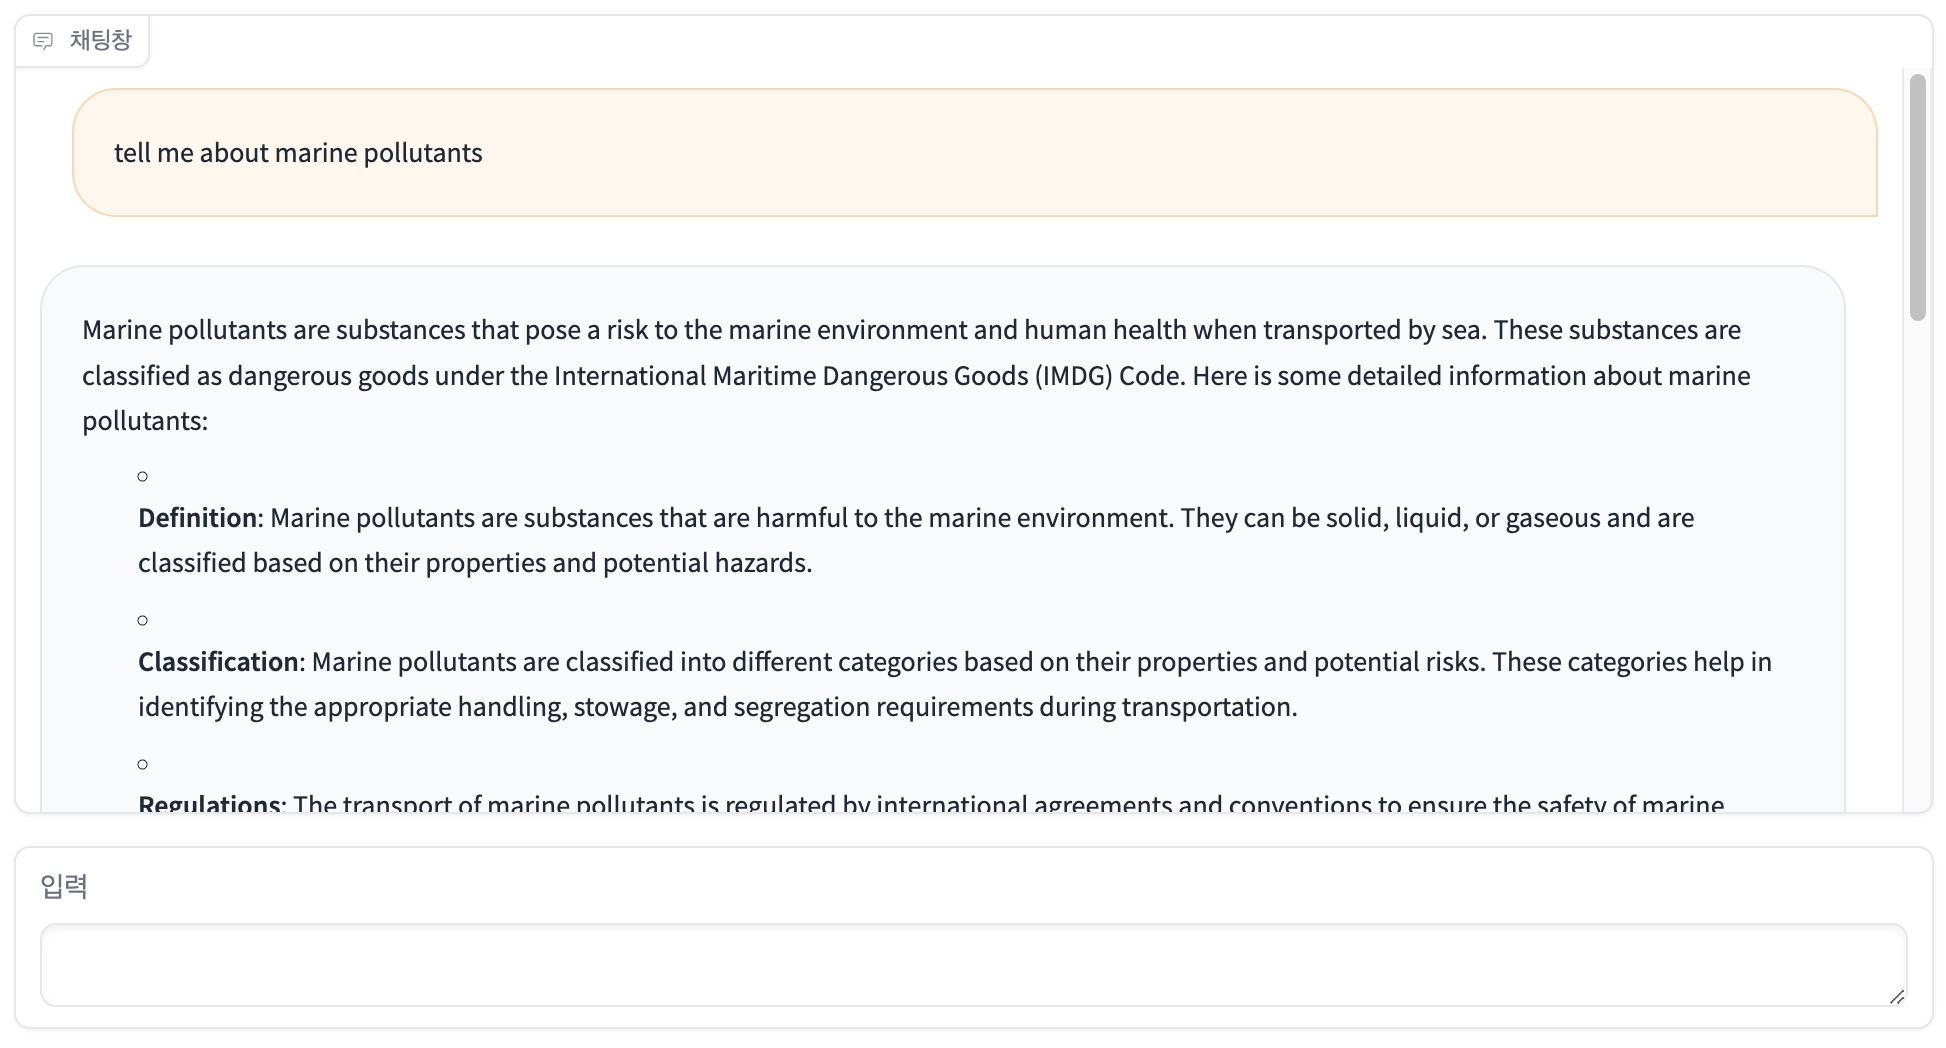

Marine pollutants are substances that pose a risk to the marine environment and human health when transported by sea. These substances are classified as dangerous goods under the International Maritime Dangerous Goods (IMDG) Code. Here is some detailed information about marine pollutants:
Definition: Marine pollutants are substances that are harmful to the marine environment. They can be solid, liquid, or gaseous and are classified based on their properties and potential hazards.
Classification: Marine pollutants are classified into different categories based on their properties and potential risks. These categories help in identifying the appropriate handling, stowage, and segregation requirements during transportation.
Regulations: The transport of marine pollutants is regulated by international agreements and conventions to ensure the safety of marine ecosystems and human health. The IMDG Code provides guidelines for the safe transport of dangerous goods, including marine pollutants, by sea.
Handling and Stowage: Proper handling and stowage of marine pollutants are crucial to prevent accidents, spills, and contamination of the marine environment. Specific instructions and provisions are outlined in the IMDG Code to ensure safe transportation.
Segregation: Segregation requirements are important to prevent incompatible substances from coming into contact with each other during transport. Segregation rules help minimize the risk of chemical reactions or accidents that could harm the marine environment.
Emergency Response: In case of spills or accidents involving marine pollutants, emergency response procedures must be followed to contain the spill, minimize environmental damage, and protect human health. Proper training and equipment are essential for effective emergency response.
Documentation: Proper documentation and labeling of marine pollutants are necessary for identification, handling, and emergency response. Clear labeling and accurate documentation help ensure that the substances are handled safely throughout the transportation process.
Compliance: It is essential for all parties involved in the transport of marine pollutants to comply with the regulations and guidelines set forth in the IMDG Code and other relevant international standards. Compliance helps prevent accidents and protect the marine environment.
Overall, the safe transport of marine pollutants is crucial to prevent environmental pollution and ensure the sustainability of marine ecosystems. Adhering to regulations, following proper handling procedures, and being prepared for emergencies are key aspects of transporting marine pollutants safely.
[1] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(644) [2] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(732) [3] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(900) [4] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(790) [5] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(772) [6] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(267) [7] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(690) [8] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(876) [9] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(927) [10] /Users/kenny_jung/Documents/GitHub/IMDG.pdf(792)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# User Test Results

### Understanding: Did the chatbot fully comprehend the user's question?
- Better understanding a general question
- Some specific question tend to lead wrong feedback

### Accuracy: Was the provided answer accurate? Did it contain any incorrect information?
- More accurate feedback is given for genric term and words basis questions

### Detail: Was the answer detailed enough, or did you desire more information?
- User who has no prior knowledge for IMDG code could be benefit for easy research IMDG code book basis

### Response Time: Were you satisfied with the speed of the chatbot's response?
- It takes about 5 to 10 seconds and reasonable time 

### Naturalness: Did the chatbot's responses feel natural, or were there areas that needed improvement?
- The way of giving feedback with natural language were bigest benifit against current solutions which is working only with explicit wording or number.

### User Experience: Was interacting with the chatbot an enjoyable experience for the user?
- Yes, it is a new way of use case enterprize solution.

### Usefulness: Was this chatbot service helpful in practical applications?
- Rather than search 1,000 pages of book, it is easy and simple to research.

### Intention to Reuse: Would you like to continue using this chatbot service in the future?
- If the chatbot could be enhanced more for technical communication, will use again.

### Suggestions for Improvement: What were the inconveniences or areas that you think could be improved based on the user's experience?
- Need to try other way of handling pdf file basis documentation especially for large amount of wordings. Also technical communication should be provided for specialist who need the support more in detailed situation and questions.